In [1]:
import pandas as pd
import numpy as np
import pytz

In [2]:
CSV_PATH = "data/heating-data_cleaned.csv"
TIME_OFFSET = np.timedelta64(1, "Y")
tz = pytz.timezone("Europe/Zurich")

In [3]:
TIME = "received_time"
DRINKING_WATER = "drinking_water"
BUFFER_MAX = "buffer_max"
BUFFER_MIN = "buffer_min"

In [4]:
ROLLING = 10

In [5]:
def load_data():
    heating_data = pd.read_csv(CSV_PATH)
    timestamps = pd.to_datetime(heating_data.pop(TIME), utc=True)
    # timestamps = timestamps + TIME_OFFSET  # shift everything 1 year into the future to have fake prediction values
    heating_data.index = timestamps
    heating_data.index = heating_data.index.tz_convert(tz)
    heating_data["heating_up_prev"] = heating_data["heating_up"].shift(1).fillna(False)
    return heating_data.sort_index()

In [6]:
df = load_data()
df

,buffer_max,buffer_min,drinking_water,heating_up,heating_up_prev
received_time,,,,,
2020-06-09 18:43:32.943731+02:00,63.3,42.9,55.7,False,False
2020-06-09 18:45:24.995442+02:00,63.3,42.9,55.7,False,False
2020-06-09 18:46:29.944035+02:00,63.3,42.8,55.4,False,False
2020-06-09 18:47:28.939817+02:00,63.3,42.9,55.9,False,False
2020-06-09 18:48:27.938373+02:00,63.3,42.9,55.6,False,False
...,...,...,...,...,...
2022-09-02 09:14:42.291005+02:00,41.4,29.7,36.6,False,False
2022-09-02 09:15:41.289580+02:00,41.4,34.3,36.6,False,False
2022-09-02 09:16:40.289253+02:00,41.4,36.1,36.4,False,False


In [7]:
df["pow_cumsum"] = df.buffer_max ** 2 + df.buffer_min ** 2 + df.drinking_water ** 2

In [8]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
buffer_max,1168600.0,50.634010,14.909075,22.40,39.6000,49.500,62.40,89.30
buffer_min,1168600.0,36.289248,9.563931,15.60,29.1000,34.800,42.30,86.30
drinking_water,1168600.0,45.441944,8.409723,16.80,39.7000,47.000,52.10,58.60
pow_cumsum,1168600.0,6330.155152,2703.355730,1065.96,4243.3325,6125.615,8210.75,18406.74


In [9]:
min_buf_max = df.buffer_max.idxmin()
min_buf_min = df.buffer_min.idxmin()
min_drinkin = df.drinking_water.idxmin()

In [10]:
min_cum_idx = df.pow_cumsum.idxmin()
max_cum_idx = df.pow_cumsum.idxmax()

In [11]:
from datetime import timedelta

<AxesSubplot: xlabel='received_time'>

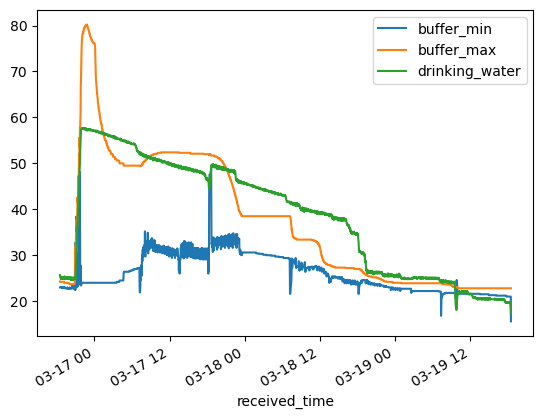

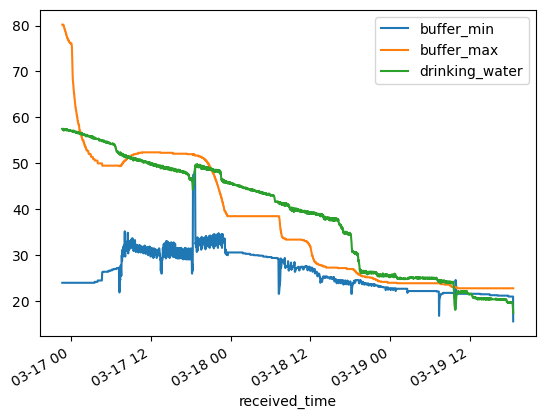

In [12]:
local_max_cum_idx = df.pow_cumsum[min_cum_idx-timedelta(days=3):min_cum_idx].idxmax()
df[["buffer_min", "buffer_max", "drinking_water"]][min_cum_idx-timedelta(days=3):min_cum_idx].plot()
df[["buffer_min", "buffer_max", "drinking_water"]][local_max_cum_idx:min_cum_idx].plot()

In [13]:
print("Lowest cumsum example")
exam_min_from = local_max_cum_idx - timedelta(hours=12)
exam_min_to = min_cum_idx + timedelta(hours=12)
print(exam_min_from)
print(exam_min_to)

Lowest cumsum example
2022-03-16 10:40:05.553146+01:00
2022-03-20 06:30:30.007373+01:00


<AxesSubplot: xlabel='received_time'>

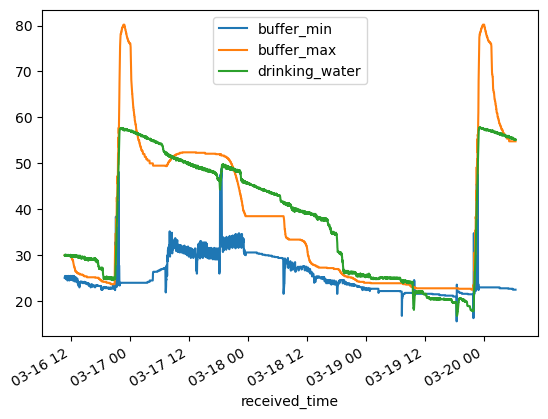

In [14]:
df[["buffer_min", "buffer_max", "drinking_water"]][exam_min_from:exam_min_to].plot()

<AxesSubplot: xlabel='received_time'>

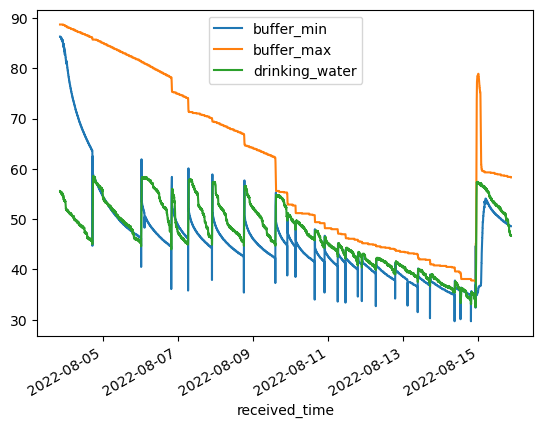

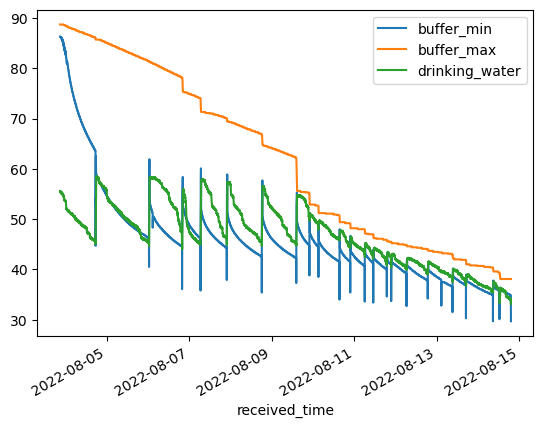

In [15]:
local_min_cum_idx = df.pow_cumsum[max_cum_idx:max_cum_idx+timedelta(days=12)].idxmin()
df[["buffer_min", "buffer_max", "drinking_water"]][max_cum_idx:max_cum_idx+timedelta(days=12)].plot()
df[["buffer_min", "buffer_max", "drinking_water"]][max_cum_idx:local_min_cum_idx].plot()

In [16]:
print("Highest cumsum example")
exam_max_from = max_cum_idx - timedelta(hours=12)
exam_max_to = local_min_cum_idx + timedelta(hours=12)
print(exam_max_from)
print(exam_max_to)

Highest cumsum example
2022-08-03 08:45:34.884219+02:00
2022-08-15 07:12:53.756487+02:00


<AxesSubplot: xlabel='received_time'>

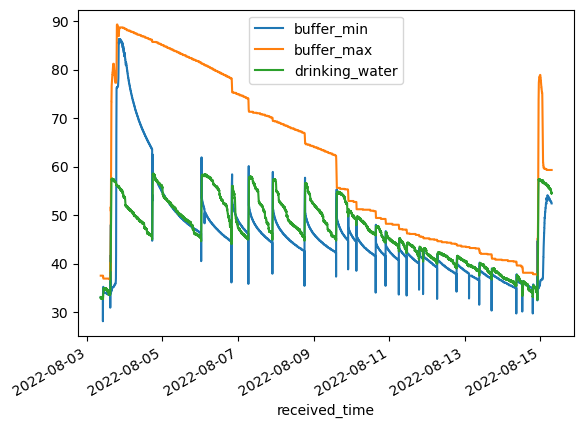

In [17]:
df[["buffer_min", "buffer_max", "drinking_water"]][exam_max_from:exam_max_to].plot()

In [18]:
# viläch machts me sinn z min im summer u im winter einisch z näh ah und es rolling average würds o gschider machä

In [19]:
df["rolling_cumsum"] = df.pow_cumsum.rolling(window=ROLLING).mean()
df

,buffer_max,buffer_min,drinking_water,heating_up,heating_up_prev,pow_cumsum,rolling_cumsum
received_time,,,,,,,
2020-06-09 18:43:32.943731+02:00,63.3,42.9,55.7,False,False,8949.79,NaN
2020-06-09 18:45:24.995442+02:00,63.3,42.9,55.7,False,False,8949.79,NaN
2020-06-09 18:46:29.944035+02:00,63.3,42.8,55.4,False,False,8907.89,NaN
2020-06-09 18:47:28.939817+02:00,63.3,42.9,55.9,False,False,8972.11,NaN
2020-06-09 18:48:27.938373+02:00,63.3,42.9,55.6,False,False,8938.66,NaN
...,...,...,...,...,...,...,...
2022-09-02 09:14:42.291005+02:00,41.4,29.7,36.6,False,False,3935.61,4316.823
2022-09-02 09:15:41.289580+02:00,41.4,34.3,36.6,False,False,4230.01,4303.418
2022-09-02 09:16:40.289253+02:00,41.4,36.1,36.4,False,False,4342.13,4301.225


In [20]:
df = df.merge(df[["buffer_max", "buffer_min", "drinking_water"]].rolling(window=ROLLING).mean(), left_index=True, right_index=True, suffixes=(None, "_rolling"))
df

,buffer_max,buffer_min,drinking_water,heating_up,heating_up_prev,pow_cumsum,rolling_cumsum,buffer_max_rolling,buffer_min_rolling,drinking_water_rolling
received_time,,,,,,,,,,
2020-06-09 18:43:32.943731+02:00,63.3,42.9,55.7,False,False,8949.79,NaN,NaN,NaN,NaN
2020-06-09 18:45:24.995442+02:00,63.3,42.9,55.7,False,False,8949.79,NaN,NaN,NaN,NaN
2020-06-09 18:46:29.944035+02:00,63.3,42.8,55.4,False,False,8907.89,NaN,NaN,NaN,NaN
2020-06-09 18:47:28.939817+02:00,63.3,42.9,55.9,False,False,8972.11,NaN,NaN,NaN,NaN
2020-06-09 18:48:27.938373+02:00,63.3,42.9,55.6,False,False,8938.66,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
2022-09-02 09:14:42.291005+02:00,41.4,29.7,36.6,False,False,3935.61,4316.823,41.4,35.46,36.63
2022-09-02 09:15:41.289580+02:00,41.4,34.3,36.6,False,False,4230.01,4303.418,41.4,35.28,36.62
2022-09-02 09:16:40.289253+02:00,41.4,36.1,36.4,False,False,4342.13,4301.225,41.4,35.28,36.59


In [21]:
df["rolling_pre_cumsum"] = df.buffer_max_rolling ** 2 + df.buffer_min_rolling ** 2 + df.drinking_water_rolling ** 2
df

,buffer_max,buffer_min,drinking_water,heating_up,heating_up_prev,pow_cumsum,rolling_cumsum,buffer_max_rolling,buffer_min_rolling,drinking_water_rolling,rolling_pre_cumsum
received_time,,,,,,,,,,,
2020-06-09 18:43:32.943731+02:00,63.3,42.9,55.7,False,False,8949.79,NaN,NaN,NaN,NaN,NaN
2020-06-09 18:45:24.995442+02:00,63.3,42.9,55.7,False,False,8949.79,NaN,NaN,NaN,NaN,NaN
2020-06-09 18:46:29.944035+02:00,63.3,42.8,55.4,False,False,8907.89,NaN,NaN,NaN,NaN,NaN
2020-06-09 18:47:28.939817+02:00,63.3,42.9,55.9,False,False,8972.11,NaN,NaN,NaN,NaN,NaN
2020-06-09 18:48:27.938373+02:00,63.3,42.9,55.6,False,False,8938.66,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2022-09-02 09:14:42.291005+02:00,41.4,29.7,36.6,False,False,3935.61,4316.823,41.4,35.46,36.63,4313.1285
2022-09-02 09:15:41.289580+02:00,41.4,34.3,36.6,False,False,4230.01,4303.418,41.4,35.28,36.62,4299.6628
2022-09-02 09:16:40.289253+02:00,41.4,36.1,36.4,False,False,4342.13,4301.225,41.4,35.28,36.59,4297.4665


In [22]:
rolling_min_cum_idx = df.rolling_cumsum.idxmin()
rolling_max_cum_idx = df.rolling_cumsum.idxmax()

<AxesSubplot: xlabel='received_time'>

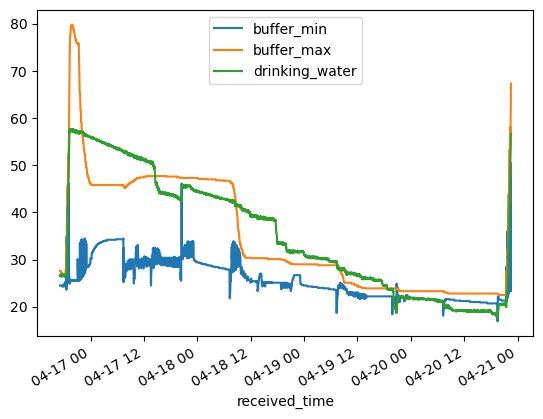

In [23]:
df[["buffer_min", "buffer_max", "drinking_water"]][rolling_min_cum_idx-timedelta(days=4.1):rolling_min_cum_idx+timedelta(hours=3)].plot()

In [24]:
pre_rolling_min_cum_idx = df.rolling_pre_cumsum.idxmin()
pre_rolling_max_cum_idx = df.rolling_pre_cumsum.idxmax()

<AxesSubplot: xlabel='received_time'>

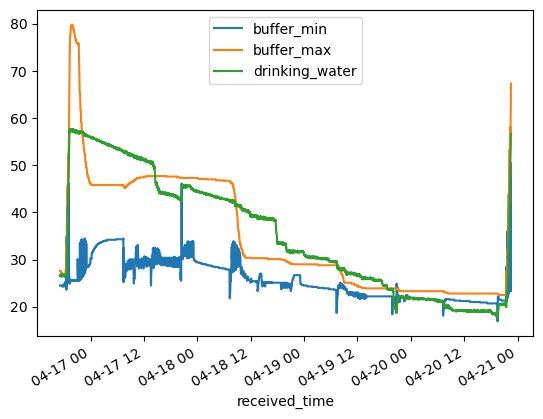

In [25]:
df[["buffer_min", "buffer_max", "drinking_water"]][pre_rolling_min_cum_idx-timedelta(days=4.1):pre_rolling_min_cum_idx+timedelta(hours=3)].plot()

In [26]:
summer = df[df.index.month.isin(range(6,10))]
summer_pre_rolling_min_cum_idx = summer.rolling_pre_cumsum.idxmin()
summer_pre_rolling_max_cum_idx = summer.rolling_pre_cumsum.idxmax()

<AxesSubplot: xlabel='received_time'>

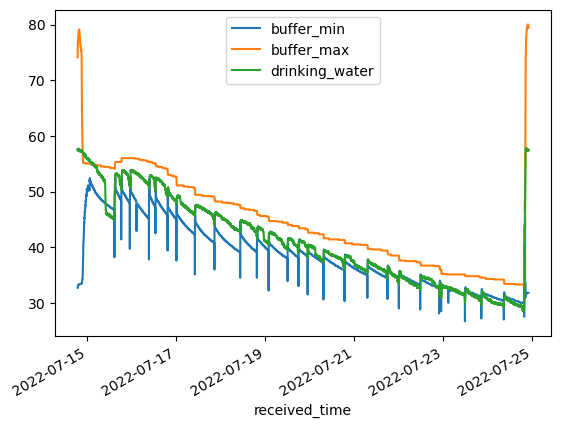

In [27]:
df[["buffer_min", "buffer_max", "drinking_water"]][summer_pre_rolling_min_cum_idx-timedelta(days=10):summer_pre_rolling_min_cum_idx+timedelta(hours=3)].plot()

In [28]:
# summerzit faht 01.05 a u winterzit 01.10

<AxesSubplot: xlabel='received_time'>

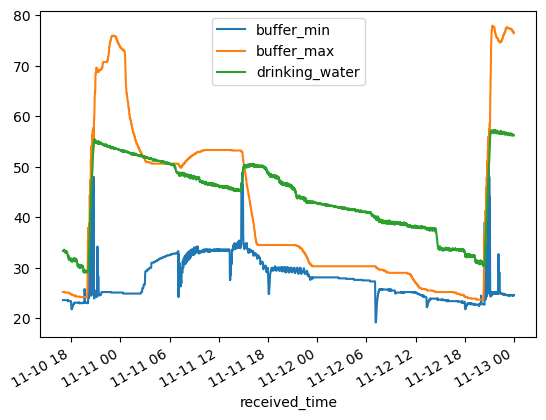

In [29]:
df[["buffer_min", "buffer_max", "drinking_water"]]["2021-11-10T17:00:00":"2021-11-13T00:00:00"].plot()

# The two definite periods to investigate are:

In [30]:
print("Summer:")
start, end = summer_pre_rolling_min_cum_idx-timedelta(days=10), summer_pre_rolling_min_cum_idx+timedelta(hours=3)
print("Start:", start)
print("End:", end)

Summer:
Start: 2022-07-14 18:57:53.703401+02:00
End: 2022-07-24 21:57:53.703401+02:00


In [31]:
print("Winter:")
start, end = pre_rolling_min_cum_idx-timedelta(days=4.1), pre_rolling_min_cum_idx+timedelta(hours=3)
print("Start:", start)
print("End:", end)

Winter:
Start: 2022-04-16 17:06:52.334715+02:00
End: 2022-04-20 22:30:52.334715+02:00


## Summer investigation

<AxesSubplot: xlabel='received_time'>

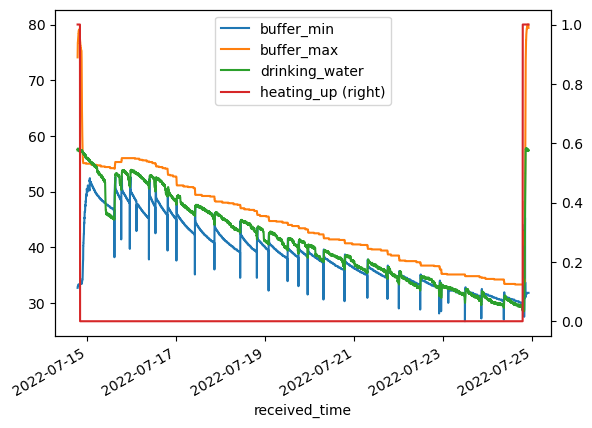

In [46]:
to_plot = df["2022-07-14 18:57:53.703401+02:00":"2022-07-24 21:57:53.703401+02:00"].reset_index()
to_plot.plot(x="received_time", y=["buffer_min", "buffer_max", "drinking_water", "heating_up"], secondary_y=["heating_up"], include_bool=True)

<AxesSubplot: xlabel='received_time'>

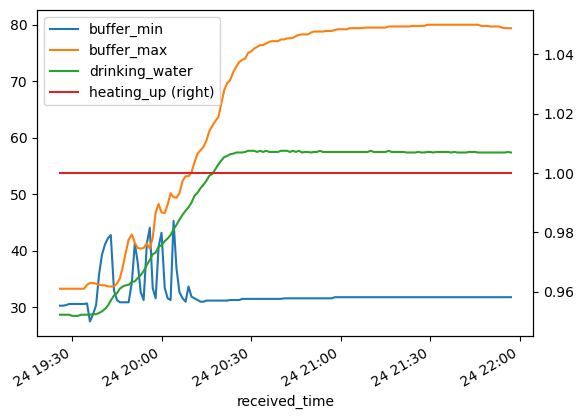

In [48]:
to_plot = df["2022-07-24 19:25:00+02:00":"2022-07-24 21:57:53.703401+02:00"].reset_index()
to_plot.plot(x="received_time", y=["buffer_min", "buffer_max", "drinking_water", "heating_up"], secondary_y=["heating_up"], include_bool=True)

In [49]:
summer_end = "2022-07-24 19:25:00+02:00"

<AxesSubplot: xlabel='received_time'>

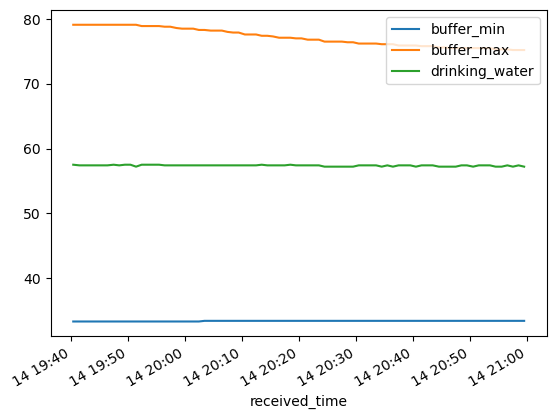

In [53]:
to_plot = df["2022-07-14 19:40:00+02:00":"2022-07-14 21:00:00+02:00"].reset_index()
to_plot.plot(x="received_time", y=["buffer_min", "buffer_max", "drinking_water"], secondary_y=["heating_up"], include_bool=True)

In [54]:
summer_start = "2022-07-14 19:40:00+02:00"

# Definitive Summer times

In [57]:
print("Summer:")
print("Start:", summer_start)
print("End:", summer_end)

Summer:
Start: 2022-07-14 19:40:00+02:00
End: 2022-07-24 19:25:00+02:00


<AxesSubplot: xlabel='received_time'>

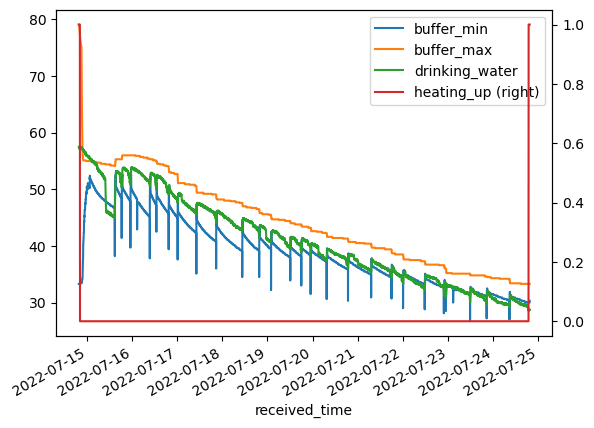

In [55]:
to_plot = df[summer_start:summer_end].reset_index()
to_plot.plot(x="received_time", y=["buffer_min", "buffer_max", "drinking_water", "heating_up"], secondary_y=["heating_up"], include_bool=True)

## Winter investigation

<AxesSubplot: xlabel='received_time'>

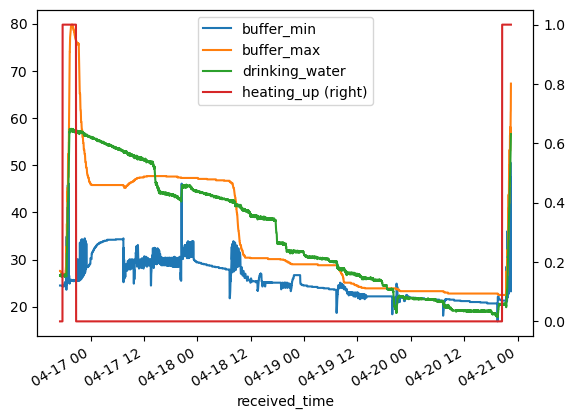

In [59]:
to_plot = df["2022-04-16 17:06:52.334715+02:00":"2022-04-20 22:30:52.334715+02:00"].reset_index()
to_plot.plot(x="received_time", y=["buffer_min", "buffer_max", "drinking_water", "heating_up"], secondary_y=["heating_up"], include_bool=True)

<AxesSubplot: xlabel='received_time'>

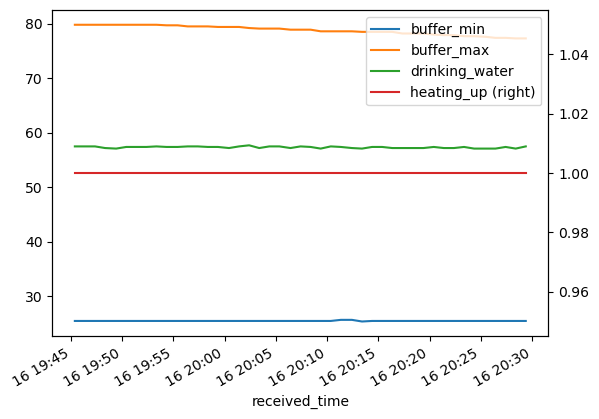

In [62]:
to_plot = df["2022-04-16 19:45:00+02:00":"2022-04-16 20:30:00+02:00"].reset_index()
to_plot.plot(x="received_time", y=["buffer_min", "buffer_max", "drinking_water", "heating_up"], secondary_y=["heating_up"], include_bool=True)

In [63]:
winter_start = "2022-04-16 19:45:00+02:00"

<AxesSubplot: xlabel='received_time'>

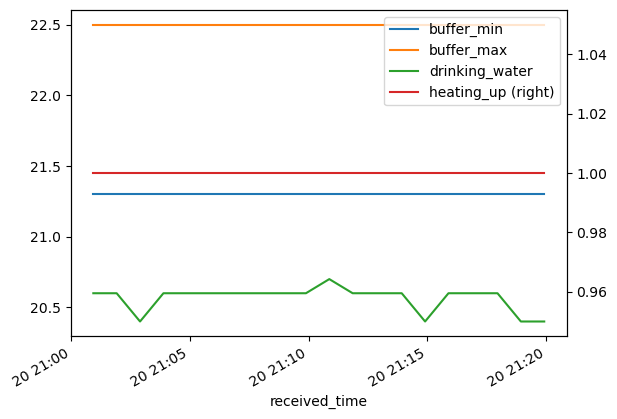

In [66]:
to_plot = df["2022-04-20 21:00:00+02:00":"2022-04-20 21:20:00+02:00"].reset_index()
to_plot.plot(x="received_time", y=["buffer_min", "buffer_max", "drinking_water", "heating_up"], secondary_y=["heating_up"], include_bool=True)

In [67]:
winter_end = "2022-04-20 21:20:00+02:00"

# Definitive Winter times

In [68]:
print("Winter:")
print("Start:", winter_start)
print("End:", winter_end)

Winter:
Start: 2022-04-16 19:45:00+02:00
End: 2022-04-20 21:20:00+02:00


<AxesSubplot: xlabel='received_time'>

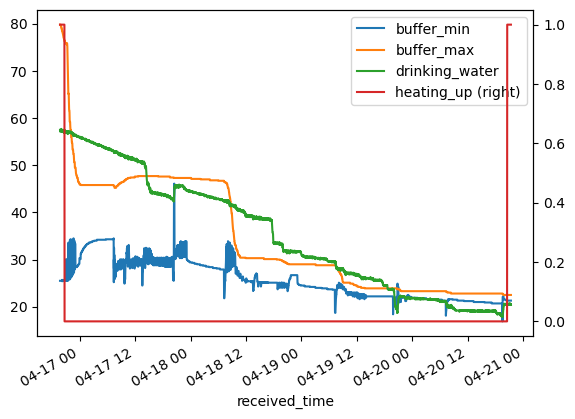

In [69]:
to_plot = df[winter_start:winter_end].reset_index()
to_plot.plot(x="received_time", y=["buffer_min", "buffer_max", "drinking_water", "heating_up"], secondary_y=["heating_up"], include_bool=True)

In [72]:
df[winter_start:winter_end].reset_index()[["received_time", "buffer_min", "buffer_max", "drinking_water"]].to_csv("data/winter_prediction.csv", index=False)
df[summer_start:summer_end].reset_index()[["received_time", "buffer_min", "buffer_max", "drinking_water"]].to_csv("data/summer_prediction.csv", index=False)

In [32]:
uga buga break please

SyntaxError: invalid syntax (3337936325.py, line 1)

In [ ]:
df.index = pd.to_datetime(df.pop("received_time"))
df

In [ ]:
df

In [ ]:
df = df.sort_index(ascending=False)
df

In [ ]:
df["heating_up_next"] = df["heating_up"].shift(1).fillna(False) # isch next wäg desc sortiert
df

In [ ]:
switching_times = df.query("not heating_up & heating_up_next").index
switching_times

In [ ]:
df["time_to_next_heating_up"] = 0

In [ ]:
df[pd.Timestamp("2022-08-14T19:22:55.049664000"):pd.Timestamp("2022-08-26T17:27:04.957240000")]

In [ ]:
for time_from, time_to in zip(switching_times, switching_times.to_series().shift(1)):
    print(time_from, "-", time_to)
    print(df[time_from:time_to])
    print(type(time_from))
    # print(df[time_from:time_to].index - time_from)
    # df[time_from:time_to]["time_to_next_heating_up"] = df[time_from:time_to].index - time_from
    # print(time_from, "-", time_to, " -> ", df[time_from:time_to])